Problem Statement¶

With the widespread use of email for communication, the issue of spam emails has become increasingly prevalent. Spam emails not only clutter users' inboxes but also pose security risks by spreading malware, phishing attempts, and fraudulent schemes. To mitigate these risks and improve user experience, there is a need for an efficient and reliable automated system capable of accurately identifying and filtering spam emails.

Develop a machine learning-based system to automatically detect spam emails in a given dataset

Objective
The primary objective of this project is to build a robust spam detection model that can accurately classify emails as spam or legitimate (ham) based on their content and metadata.

Data Description

The dataset consists of a collection of emails labeled as either spam or legitimate (ham). Each email sample is represented by features such as sender email address, subject line, email body content, and attachments. The dataset provides a balanced distribution of spam and ham emails, enabling the development of a model that can effectively differentiate between the two classes.

In [1]:
# Import libraries
import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import warnings
import plotly.express as px
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving emails.csv.zip to emails.csv (1).zip
User uploaded file "emails.csv (1).zip" with length 2994798 bytes


In [3]:
import zipfile
import os

# Unzip the uploaded file
zip_filename = "emails.csv.zip"
extract_dir = "unzipped_emails"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")


Extraction completed.


In [4]:
import pandas as pd
from pathlib import Path

# Find the first CSV in the extracted directory
csv_files = list(Path(extract_dir).rglob("*.csv"))

if csv_files:
    df = pd.read_csv(csv_files[0])
    display(df.head())  # Preview first 5 rows
else:
    print("No CSV file found in the extracted folder.")


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


Understanding the data

text :- Contains the subject of the email

spam :- contains binary values '0' indicating ham and '1' indicating spam

In [5]:
import pandas as pd
from pathlib import Path

# Load CSV (assuming you've unzipped it already)
csv_files = list(Path("unzipped_emails").rglob("*.csv"))

# Load into DataFrame
if csv_files:
    spam_df = pd.read_csv(csv_files[0])

    # Preview structure
    print("✅ DataFrame loaded successfully.")
    spam_df.info()
else:
    print("❌ CSV not found.")


✅ DataFrame loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


Exploratory Data Analysis¶
Statistics Summary
Indentifying Missing values
Handling Missing values
Removing Duplicate records
Visualization


Statistics Summary

In [6]:
spam_df.describe().T

,count,mean,std,min,25%,50%,75%,max
spam,5728.0,0.238827,0.426404,0.0,0.0,0.0,0.0,1.0


In [7]:
spam_df.dtypes

,0
text,object
spam,int64


In [8]:
len(spam_df['text'].unique())

5695

In [9]:
# check for missing values
#Check Null values
spam_df.isnull().sum()

,0
text,0
spam,0


In [10]:
# check for duplicate record
spam_df.duplicated().sum()

np.int64(33)

In [11]:
#Fetch all duplicate values
duplicate=spam_df[spam_df.duplicated(keep='last')]
duplicate.head()

,text,spam
1417,"Subject: day off tuesday stinson , i would l...",0
1508,Subject: re : enron weather research good aft...,0
1532,Subject: schedule and more . . dr . kaminski ...,0
1667,"Subject: re : summer work . . jinbaek , this...",0
1749,"Subject: term paper dr . kaminski , attached...",0


In [12]:
#Remove Duplicate Records
spam_df.drop_duplicates(inplace=True)
spam_df.duplicated().sum()

np.int64(0)

In [13]:
# Rename names columns
spam_df=spam_df.rename(columns={'spam':'label'})

In [14]:
spam_df["length"] = spam_df["text"].apply(len)
spam_df.sort_values(by='length', ascending=False).head(3)

,text,label,length
2650,Subject: from the enron india newsdesk - april...,0,43952
1380,Subject: from the enron india newsdesk - april...,0,43937
2338,Subject: from the enron india newsdesk - april...,0,31055


In [15]:
# VISUALIZATION
counts = spam_df['label'].value_counts().reset_index()
counts.columns = ['Label', 'Count']
# Create a bar plot using Plotly Express
fig = px.bar(counts, x='Label', y='Count', color='Label')
fig.update_layout(title='Number of Spam and Ham Emails', xaxis_title='Label', yaxis_title='Count')
fig.update_xaxes(tickvals=[0, 1], ticktext=['Ham', 'Spam'])
fig.show()

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

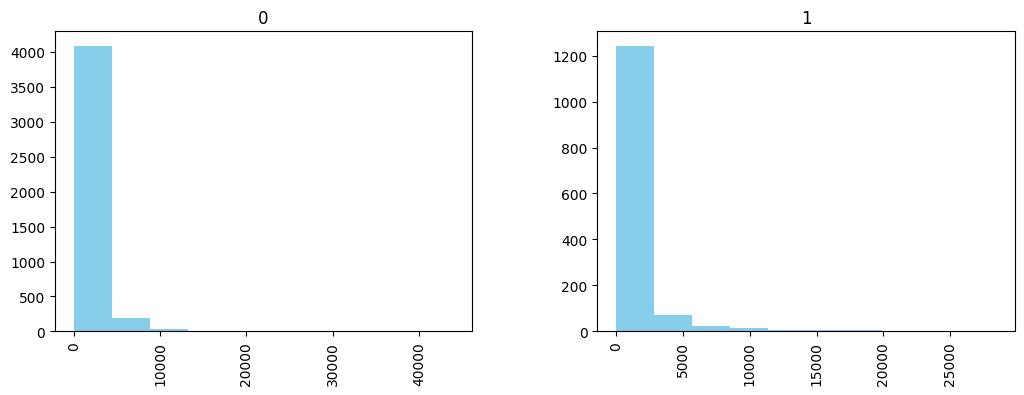

In [16]:
spam_df.hist(column = 'length', by ='label',figsize=(12,4), bins = 10,color='skyblue')

Data preprocessing¶

Remove punctuations

Lowering the case

Remove stop words

Lemmatization

Identify spam and ham words using N-gram model

In [17]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
import nltk
nltk.download('punkt')  # ✅ This is the one that fixes it

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'^subject:\s*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens)

In [23]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Required for lemmatization in some setups


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [25]:
import re
import string

def preprocess_text(text):
    text = str(text).lower()  # lowercase & ensure string
    text = re.sub(r'^subject:\s*', '', text)  # remove Subject:
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

spam_df["preprocessed_text"] = spam_df["text"].apply(preprocess_text)
spam_df.head()


,text,label,length,preprocessed_text
0,Subject: naturally irresistible your corporate...,1,1484,naturally irresistible your corporate identity...
1,Subject: the stock trading gunslinger fanny i...,1,598,the stock trading gunslinger fanny is merrill ...
2,Subject: unbelievable new homes made easy im ...,1,448,unbelievable new homes made easy im wanting to...
3,Subject: 4 color printing special request add...,1,500,color printing special request additional info...
4,"Subject: do not have money , get software cds ...",1,235,do not have money get software cds from here s...


N GRAM

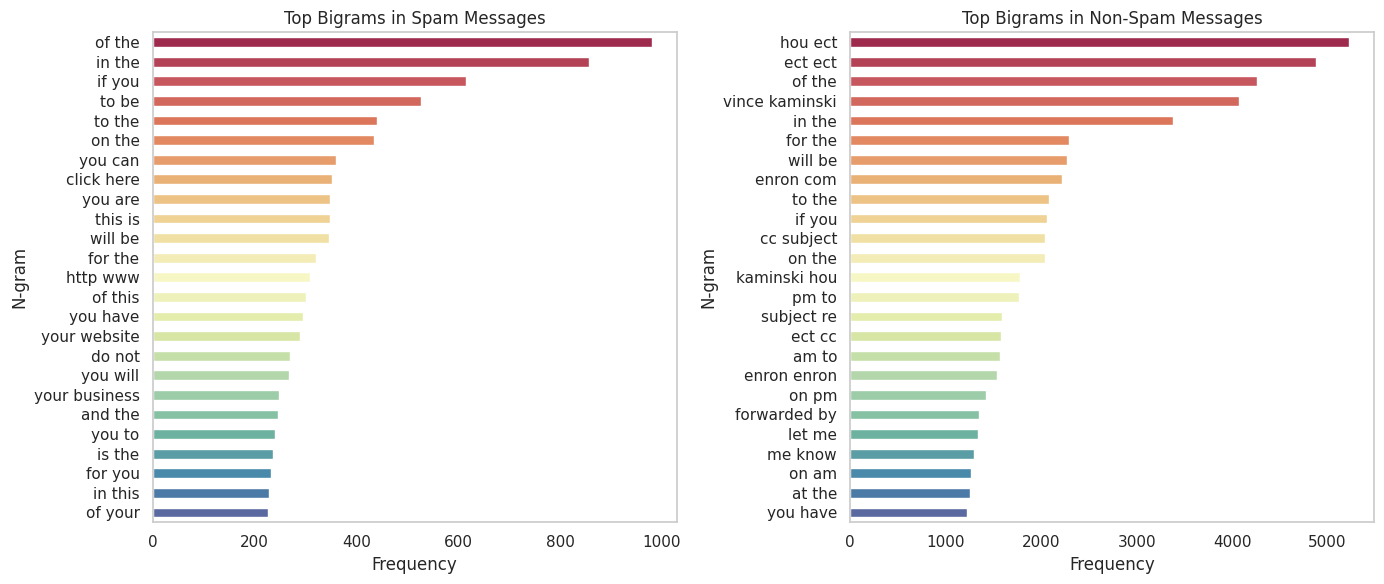

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

sns.set(style="whitegrid")

def plot_ngrams(ax, texts, ngram_range=(2, 2), num_top_ngrams=25, title=''):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    ngram_counts = X.sum(axis=0).A1
    ngram_dict = dict(zip(feature_names, ngram_counts))
    sorted_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)
    top_ngrams = sorted_ngrams[:num_top_ngrams]

    sns.barplot(ax=ax, x=[count for _, count in top_ngrams],
                y=[ngram for ngram, _ in top_ngrams],
                orient="h",
                width=0.5,
                palette='Spectral')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-gram')
    ax.set_title(title)
    ax.grid(axis='x')

spam_texts = spam_df[spam_df['label'] == 1]['preprocessed_text']
non_spam_texts = spam_df[spam_df['label'] == 0]['preprocessed_text']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ngrams(axes[0], spam_texts, title='Top Bigrams in Spam Messages')
plot_ngrams(axes[1], non_spam_texts, title='Top Bigrams in Non-Spam Messages')
plt.tight_layout()
plt.show()


Feature Engineering¶

1.Count Vectorizer


2.TF-IDF Vectorizer (Term Frequency Inverse Document Frequency)


1.Count Vectorizer


Count Vectorizer is a simple method used to convert a collection of text documents into a matrix of token counts. It works by converting text documents into a sparse matrix representation where each row corresponds to a document, and each column corresponds to a unique word in the corpus (collection of documents). The value in each cell of the matrix represents the frequency of occurrence of the corresponding word in the corresponding document


fit_transform learns the vocabulary of the text data (i.e., all unique words) and transforms the text data into a sparse matrix representation called a bag-of-words (BoW) representation

In [27]:
# Initialize count vectorizer
vectorizer = CountVectorizer()
# Bag of words
bow_text = vectorizer.fit_transform(spam_df["preprocessed_text"])
# Fetch the vocabulary set
print(f"10 Bag Of Words Features: {vectorizer.get_feature_names_out()[100:110]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

10 Bag Of Words Features: ['absent' 'absolute' 'absolutely' 'absolutes' 'absolve' 'absolved'
 'absorb' 'absorbing' 'absorbowac' 'absorbs']
Total number of vocab words: 33715


In [28]:
# transform only transforms the text data into BoW representation using the vocabulary learned during fitting. It does not re-learn the vocabulary.

# Convert strings to vectors using BoW
transformed_bow = vectorizer.transform(spam_df["preprocessed_text"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {transformed_bow.shape}")
print(f"Amount of non-zero occurrences: {transformed_bow.nnz}")

Shape of sparse matrix: (5695, 33715)
Amount of non-zero occurrences: 657003


2. TF-IDF Vectorizer

TF-IDF Vectorizer is another technique for text feature extraction, but it goes beyond simple word counts. It considers both the importance of a word within a document (term frequency) and its overall importance across the entire document collection (inverse document frequency).

Term Frequency (TF): Similar to CountVectorizer, TF-IDF calculates the frequency of each word in a document. However, it often normalizes this value by dividing by the document's total word count. This prevents documents with more words from getting higher weightage solely based on word count.

Inverse Document Frequency (IDF): IDF focuses on the significance of a word across the entire document collection. It downplays the importance of common words that appear frequently in many documents and emphasizes words that are unique or distinctive to a particular document

By multiplying TF and IDF scores for each word in a document, TF-IDF Vectorizer creates a weight that reflects a word's importance within a specific document relative to the entire document collectio

In [29]:
# TF-IDF
tfidf_transformer = TfidfTransformer().fit(transformed_bow)
# Transform entire BoW into tf-idf corpus
text_tfidf = tfidf_transformer.transform(transformed_bow)
print(text_tfidf.shape)

(5695, 33715)


Model selction
Split the data into train and test
Classification Model
Support vector machine (SVM) classification model
Random Forest Classification Model

Evaluate the model

1. Split the data into train and test

we have split the data as 80-20

In [30]:
# Split the dataset to train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    text_tfidf, spam_df["label"], test_size=0.2
)

print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")

print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (4556, 33715)
train dataset label size: (4556,)
test dataset features size: (1139, 33715)
test dataset label size: (1139,)


2. classification model


Initialize SVM model

Train the SVM model

Make predictions on the test data

Confusion Matrix

Evaluate the model

In [31]:
def evaluate_model(model, x_test, y_test, model_name="Model"):

  # Predict labels on testing data
  y_pred = model.predict(x_test)

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)

  # Extract TP, TN, FP, FN
  TN, FP, FN, TP = conf_matrix.ravel()

  # Calculate various performance metrics
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  specificity = TN / (TN + FP)
  miss_rate = FN / (FN + TP)

  # Calculate mean accuracy using cross-validation
  mean_accuracy = cross_val_predict(model, x_train, y_train, cv=10).mean()

  # Calculate mean square error (for regression tasks, not applicable here)
  mse = mean_squared_error(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, output_dict=True)
  metrics = {
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-score": f1,
        "Specificity": specificity,
        "Miss Rate": miss_rate,
        "Mean Accuracy": mean_accuracy,
        "Mean Square Error": mse,
        "Classification Report": classification_rep
    }
  # Print evaluation metrics
  print(f"\033[1m EVALUATION METRICS ({model_name}) \033[0m")
  print(f"\n \033 ---------------------------------------------------------------- \033[0m")
  print("\nTrue Positives (TP):", TP)
  print("True Negatives (TN):", TN)
  print("False Positives (FP):", FP)
  print("False Negatives (FN):", FN)
  print("\nAccuracy   : ", accuracy)
  print("Recall       : ", recall)
  print("Precision    : ", precision)
  print("F1-score     : ", f1)
  print("Specificity  : ", specificity)
  print("Miss Rate    : ", miss_rate)
  print("Mean Accuracy: ", mean_accuracy)
  print("Mean Square Error:", mse)  # Not applicable for classification
  print(f" \033 ---------------------------------------------------------------- \033[0m")

  # Print classification report
  print("\033[1m Classification Report: \033[0m")
  print(classification_report(y_test, y_pred))
  print(f"\n \033 ---------------------------------------------------------------- \033[0m")
  print("\033[1m Confusion Matrix \033[0m")
  # Plot the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
  disp.plot(cmap='bone_r')  # specify the colormap for better visualization
  plt.show()
  return metrics,y_pred

 EVALUATION METRICS (SVM) 

  ---------------------------------------------------------------- 

True Positives (TP): 248
True Negatives (TN): 883
False Positives (FP): 1
False Negatives (FN): 7

Accuracy   :  0.9929762949956101
Recall       :  0.9725490196078431
Precision    :  0.9959839357429718
F1-score     :  0.9841269841269841
Specificity  :  0.998868778280543
Miss Rate    :  0.027450980392156862
Mean Accuracy:  0.2370500438981563
Mean Square Error: 0.007023705004389816
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       884
           1       1.00      0.97      0.98       255

    accuracy                           0.99      1139
   macro avg       0.99      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


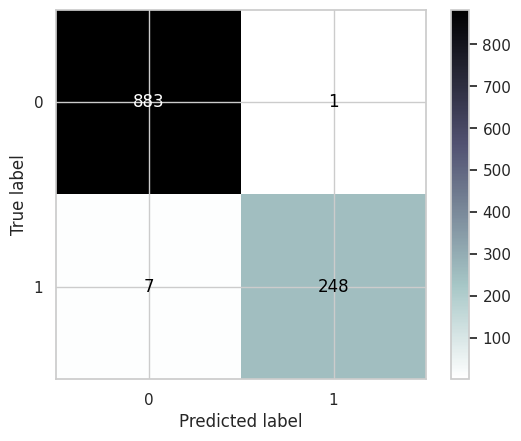

In [32]:
# Train SVM model
svm_model = SVC()
svm_model.fit(x_train, y_train)
# Evaluate SVM model
svm_metrics,y_pred_svm = evaluate_model(svm_model, x_test, y_test, model_name="SVM")

Metric	Value	Interpretation
True Positives (TP)	 248	 Spam emails correctly identified as spam

True Negatives (TN)	883	Non-spam emails correctly identified as non-spam

False Positives (FP)	1	Non-spam emails incorrectly marked as spam (Type I error)

False Negatives (FN)	7	Spam emails missed by the classifier (Type II error)

Accuracy	0.993	Overall, 99.3% emails correctly classified

Recall (Sensitivity)	0.973	97.3% of actual spam detected (very good at catching spam)

Precision	0.996	When it predicts spam, it’s right 99.6% of the time (very few false alarms)

F1-score	0.984	Balanced metric combining precision & recall — excellent overall performance

Specificity	0.999	99.9% of non-spam correctly identified (very few false positives)

Miss Rate	0.027	Only 2.7% of spam missed — quite low

Mean Accuracy	0.237	This looks suspiciously low — likely unrelated or incorrectly calculated

Mean Square Error (MSE)	0.007	Low error rate in prediction probability (good)

 EVALUATION METRICS (Random Forest) 

  ---------------------------------------------------------------- 

True Positives (TP): 214
True Negatives (TN): 883
False Positives (FP): 1
False Negatives (FN): 41

Accuracy   :  0.9631255487269534
Recall       :  0.8392156862745098
Precision    :  0.9953488372093023
F1-score     :  0.9106382978723404
Specificity  :  0.998868778280543
Miss Rate    :  0.1607843137254902
Mean Accuracy:  0.20522388059701493
Mean Square Error: 0.03687445127304653
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       884
           1       1.00      0.84      0.91       255

    accuracy                           0.96      1139
   macro avg       0.98      0.92      0.94      1139
weighted avg       0.96      0.96      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


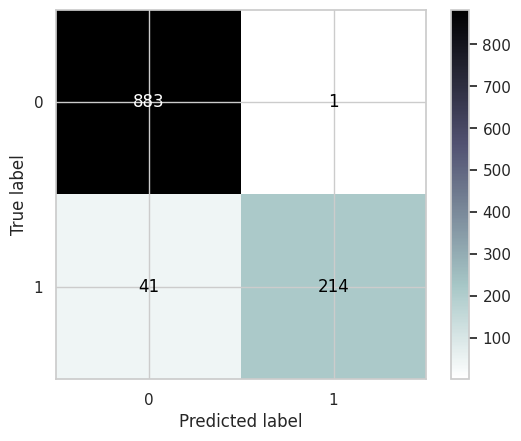

In [33]:
# Train Random Forest model
randomForest_model = RandomForestClassifier()
randomForest_model.fit(x_train, y_train)
# Evaluate Random Forest model
rf_metrics,y_pred_rf = evaluate_model(randomForest_model, x_test, y_test, model_name="Random Forest")

 EVALUATION METRICS (Decision Tree) 

  ---------------------------------------------------------------- 

True Positives (TP): 240
True Negatives (TN): 847
False Positives (FP): 37
False Negatives (FN): 15

Accuracy   :  0.9543459174714662
Recall       :  0.9411764705882353
Precision    :  0.8664259927797834
F1-score     :  0.9022556390977443
Specificity  :  0.9581447963800905
Miss Rate    :  0.058823529411764705
Mean Accuracy:  0.2515364354697103
Mean Square Error: 0.0456540825285338
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       884
           1       0.87      0.94      0.90       255

    accuracy                           0.95      1139
   macro avg       0.92      0.95      0.94      1139
weighted avg       0.96      0.95      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix

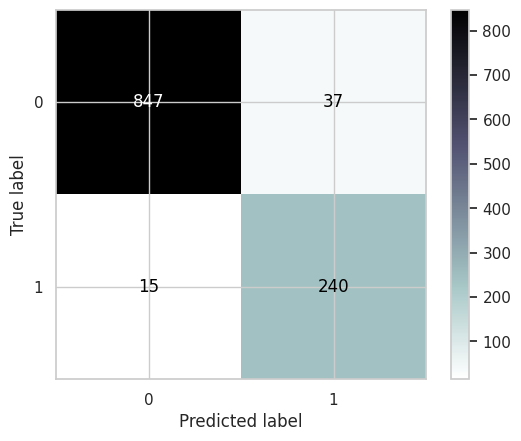

In [34]:
decisionTree_model = DecisionTreeClassifier()
decisionTree_model.fit(x_train, y_train)
dt_metrics,y_pred_dt = evaluate_model(decisionTree_model, x_test, y_test, model_name="Decision Tree")

 EVALUATION METRICS (Naive Bayes) 

  ---------------------------------------------------------------- 

True Positives (TP): 240
True Negatives (TN): 847
False Positives (FP): 37
False Negatives (FN): 15

Accuracy   :  0.9543459174714662
Recall       :  0.9411764705882353
Precision    :  0.8664259927797834
F1-score     :  0.9022556390977443
Specificity  :  0.9581447963800905
Miss Rate    :  0.058823529411764705
Mean Accuracy:  0.2521949078138718
Mean Square Error: 0.0456540825285338
  ---------------------------------------------------------------- 
 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       884
           1       0.87      0.94      0.90       255

    accuracy                           0.95      1139
   macro avg       0.92      0.95      0.94      1139
weighted avg       0.96      0.95      0.96      1139


  ---------------------------------------------------------------- 
 Confusion Matrix 


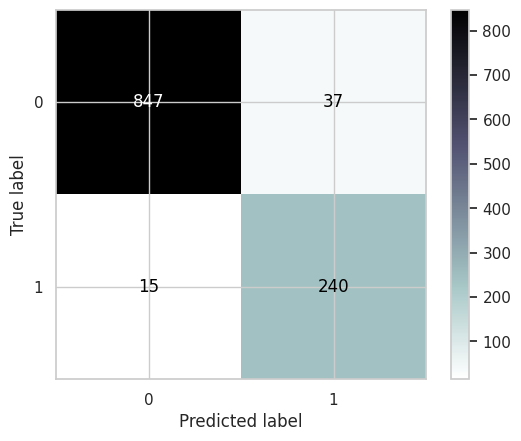

In [35]:
NaiveBayes_model = GaussianNB()
NaiveBayes_model.fit(x_train.toarray(), y_train)
nb_metrics,y_pred_nb = evaluate_model(decisionTree_model, x_test.toarray(), y_test, model_name="Naive Bayes")

In [36]:
svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)
rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred_rf)
auc_rfc = auc(rf_fpr, rf_tpr)
dt_fpr, dt_tpr, threshold = roc_curve(y_test, y_pred_dt)
auc_rfc = auc(dt_fpr, dt_tpr)
nb_fpr, nb_tpr, threshold = roc_curve(y_test, y_pred_nb)
auc_rfc = auc(nb_fpr, nb_tpr)

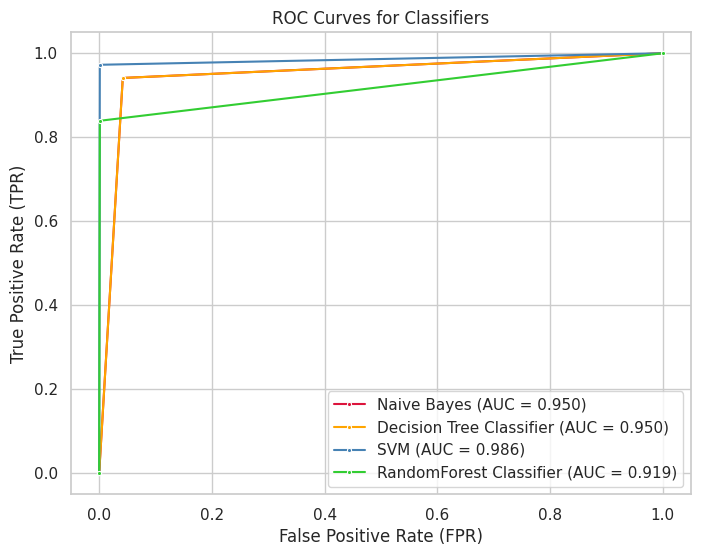

In [37]:
classifiers = {
    'Naive Bayes': (y_pred_nb, nb_fpr, nb_tpr),
    'Decision Tree Classifier': (y_pred_dt, dt_fpr, dt_tpr),
    'SVM': (y_pred_svm, svm_fpr, svm_tpr),
    'RandomForest Classifier': (y_pred_rf, rf_fpr, rf_tpr)
}

plt.figure(figsize=(8, 6), dpi=100)
colors=['crimson','orange','steelblue','limegreen']


for i, (clf_name, (y_pred, fpr, tpr)) in enumerate(classifiers.items()):
    auc_score = roc_auc_score(y_test, y_pred)  # Calculate AUC score using roc_auc_score
    sns.lineplot(x=fpr, y=tpr, marker='.', label=f'{clf_name} (AUC = {auc_score:.3f})', color=colors[i])

# Loop through classifiers and plot ROC curves
#for clf_name, (y_pred, fpr, tpr) in classifiers.items():
#    auc_score = roc_auc_score(y_test, y_pred)  # Calculate AUC score using roc_auc_score
#    sns.lineplot(x=fpr, y=tpr, marker='.', label=f'{clf_name} (AUC = {auc_score:.3f})')  # Use seaborn lineplot

# plot
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Classifiers')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
# MODEL PERFORMANCE COMPARISON
# Extract metric names and values
metric_names = list(svm_metrics.keys())
svm_values = [svm_metrics[key] for key in metric_names if key != 'Classification Report']
rf_values = [rf_metrics[key] for key in metric_names if key != 'Classification Report']
dt_values = [dt_metrics[key] for key in metric_names if key != 'Classification Report']
nb_values = [nb_metrics[key] for key in metric_names if key != 'Classification Report']

length = len(metric_names)-1

length_svm = len(svm_values)
length_rf = len(rf_values)
length_dt = len(dt_values)
length_nb = len(nb_values)

print(length,length_svm,length_rf,length_dt,length_nb)
print()

8 8 8 8 8



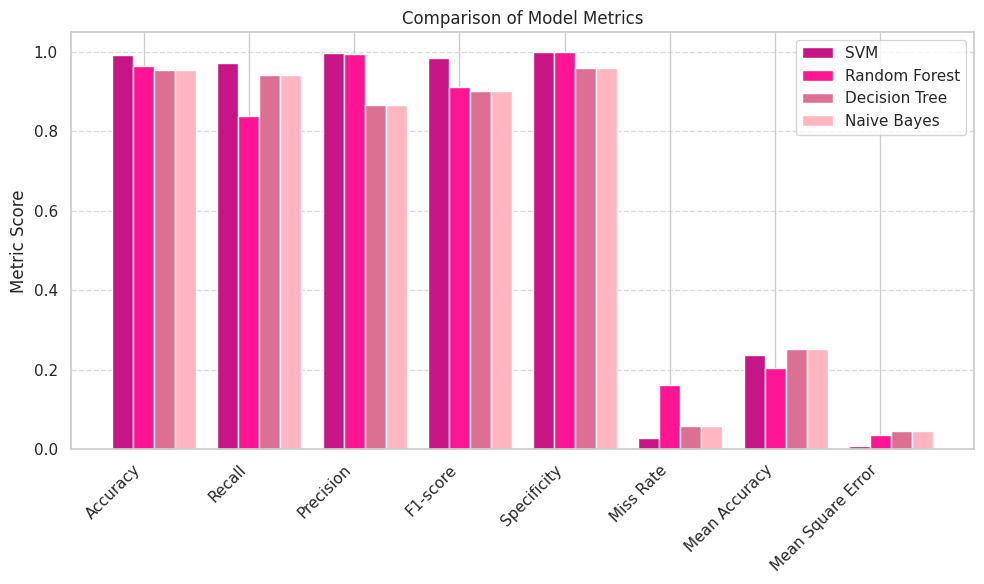

In [39]:
# Create a bar chart
plt.figure(figsize=(10, 6))
x = np.arange(length)
width = 0.2

# Plot comparison
#plt.bar(x, svm_values, width, label='SVM', color='darkolivegreen')
#plt.bar(x + width, rf_values, width, label='Random Forest', color='limegreen')
# Plot bars for each model
plt.bar(x - width, svm_values, width, label='SVM', color='mediumvioletred')
plt.bar(x, rf_values, width, label='Random Forest', color='deeppink')
plt.bar(x + width, dt_values, width, label='Decision Tree', color='palevioletred')
plt.bar(x + 2*width, nb_values, width, label='Naive Bayes', color='lightpink')


plt.xticks(x, [name for name in metric_names if name != 'Classification Report'], rotation=45, ha='right')
plt.ylabel('Metric Score')
plt.title('Comparison of Model Metrics')
plt.legend()

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Conclusion


SVM:


Best overall performance across almost all metrics.


Highest accuracy (99.3%), recall (97.3%), and precision (99.6%).


Very few false negatives and false positives.


Ideal if you want to catch almost all spam while minimizing false alarms.


Random Forest:


Good precision (99.5%) and specificity (99.9%) but noticeably lower recall (83.9%).


Higher false negatives means it misses more spam compared to SVM.


Still a strong classifier, but less sensitive to spam detection.


Decision Tree and Naive Bayes:


Similar performance with about 95.4% accuracy.


Balanced recall (~94%) and precision (~87%), but more false positives (37).


More false alarms compared to SVM and Random Forest.


Suitable if interpretability or speed is a priority.